## Машинное обучение для проекта

__В этом файле у нас будет часть с построением моделей.__
<br> Сначала подгрузим нужные библиотеки...

In [122]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

В первую очередь мы будем решать задачу __предсказания посещаемости__ с помощью линейной регрессии. <br>
__Мотивация:__ клубы могут неплохо зарабатывать за счет продажи билетов. Почему бы не играть таким образом, чтобы это привлекало много болельщиков? Решение этой задачи поможет нам узнать, какие факторы являются определяющими для увеличения/снижения посещаемости. 

In [123]:
df = pd.read_csv('final_football_file.csv')

In [124]:
df.sample(5)

,Unnamed: 0,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,...,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game),League,Relegated
164,164,5,Real Sociedad,38,0.45,0.29,0.26,1.00,0.55,1.63,...,1,51.08,17.45,49.8,8.29,22.68,14.82,0.13,La Liga,0
389,389,12,Wolfsburg,34,0.35,0.18,0.47,1.59,-0.32,1.24,...,1,58.35,18.26,54.3,11.41,27.26,21.76,0.26,Bundesliga,0
453,453,4,Dortmund,34,0.44,0.29,0.26,1.38,0.50,1.62,...,0,43.29,17.06,52.9,9.88,30.32,19.32,0.50,Bundesliga,0
372,372,13,Werder Bremen,34,0.29,0.18,0.53,1.88,-0.38,1.06,...,2,58.44,18.56,50.4,9.44,26.94,23.21,0.21,Bundesliga,0
581,581,14,Udinese,38,0.32,0.11,0.58,1.66,-0.39,1.05,...,5,50.89,14.18,48.3,12.08,28.34,26.11,0.34,Serie A,0


In [125]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

Для начала удалим столбцы с MP и Squad. Первый вообще не нужен, а второй будет слишком сильно спойлерить - по команде легко определить посещаемость. 

In [126]:
df.drop(['MP', 'Squad'], axis=1, inplace=True)
df.head(5)

,Rk,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),xGD/90,Attendance,...,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game),League,Relegated
0,1,0.74,0.13,0.13,0.87,1.61,2.34,0.84,1.23,53249.0,...,1,49.11,11.53,54.6,5.87,18.26,10.58,0.21,Premier League,0
1,2,0.68,0.16,0.16,1.13,1.18,2.21,1.11,0.79,60191.0,...,1,52.21,12.79,46.5,6.24,21.18,15.76,0.58,Premier League,0
2,3,0.61,0.16,0.24,1.13,0.39,1.97,1.33,0.45,73671.0,...,1,57.63,12.24,51.7,9.26,26.58,20.29,0.26,Premier League,0
3,4,0.50,0.37,0.13,0.87,0.92,1.87,1.04,0.85,52127.0,...,2,54.34,14.55,56.4,8.76,24.74,17.89,0.26,Premier League,0
4,5,0.50,0.26,0.24,1.24,0.74,1.76,1.34,0.57,53163.0,...,2,58.18,12.68,51.4,8.76,24.29,14.95,0.50,Premier League,0


Далее нужно удалить данные по сезону 2020-2021. Мы хотим предсказывать посещаемость, а этот ковидный сезон будет нам все портить.

In [127]:
df = df[df['Season'] != '2020-2021']
df.shape[0]

490

Потом нужно удалить сезон - нам он вообще не нужен.

In [128]:
df.drop(['Season'], axis=1, inplace=True)
df.head(5)

,Rk,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),xGD/90,Attendance,...,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game),League,Relegated
0,1,0.74,0.13,0.13,0.87,1.61,2.34,0.84,1.23,53249.0,...,1,49.11,11.53,54.6,5.87,18.26,10.58,0.21,Premier League,0
1,2,0.68,0.16,0.16,1.13,1.18,2.21,1.11,0.79,60191.0,...,1,52.21,12.79,46.5,6.24,21.18,15.76,0.58,Premier League,0
2,3,0.61,0.16,0.24,1.13,0.39,1.97,1.33,0.45,73671.0,...,1,57.63,12.24,51.7,9.26,26.58,20.29,0.26,Premier League,0
3,4,0.50,0.37,0.13,0.87,0.92,1.87,1.04,0.85,52127.0,...,2,54.34,14.55,56.4,8.76,24.74,17.89,0.26,Premier League,0
4,5,0.50,0.26,0.24,1.24,0.74,1.76,1.34,0.57,53163.0,...,2,58.18,12.68,51.4,8.76,24.29,14.95,0.50,Premier League,0


Далее поделим данные на тренировочную и тестовую выборку (в пропорции 70 к 30). Стандартизацию признаков проведем позднее.

In [129]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Attendance'], axis=1), df['Attendance'],
                                                    test_size=0.3, random_state=13) 
X_train.head()

,Rk,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),xGD/90,Top Team Scorer (per game),...,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game),League,Relegated
454,5,0.44,0.29,0.26,1.29,0.41,1.62,1.14,0.55,0.41,...,0,50.50,16.24,47.2,11.47,30.44,18.26,0.26,Bundesliga,0
444,13,0.24,0.35,0.41,1.79,-0.44,1.06,1.80,-0.60,0.29,...,0,48.50,16.26,45.3,11.00,27.76,25.94,0.35,Bundesliga,0
460,11,0.29,0.35,0.35,1.18,-0.09,1.24,1.33,-0.18,0.18,...,2,40.24,18.71,50.8,12.38,30.03,21.71,0.53,Bundesliga,0
423,10,0.32,0.24,0.44,1.74,-0.32,1.21,1.60,-0.34,0.21,...,2,50.74,17.97,53.5,12.06,28.38,23.35,0.35,Bundesliga,0
274,15,0.24,0.29,0.47,1.39,-0.42,1.00,1.34,-0.30,0.13,...,2,52.29,10.97,47.5,11.32,28.05,17.26,0.21,Ligue 1,0


Превратим информацию о лигах в dummy-переменные.

In [130]:
league_info = pd.DataFrame(X_train['League'])
league_info = pd.get_dummies(league_info, columns=['League'])
league_info.head(5)

,League_Bundesliga,League_La Liga,League_Ligue 1,League_Premier League,League_Serie A
454,1,0,0,0,0
444,1,0,0,0,0
460,1,0,0,0,0
423,1,0,0,0,0
274,0,0,1,0,0


Сохранили инфу про лиги в отдельную табличку - теперь можно удалить из исходной.

In [131]:
X_train.drop(['League'], axis=1, inplace=True)

Не хотим стандартизировать место команды в итоговом зачете - сохраним в отдельную табличку тоже, потом приделаем обратно.

In [132]:
rank_info = pd.DataFrame(X_train['Rk'])
X_train.drop(['Rk'], axis=1, inplace=True)

И вылетом.

In [133]:
releg_info = pd.DataFrame(X_train['Relegated'])
X_train.drop(['Relegated'], axis=1, inplace=True)

Стандартизируем признаки, чтобы все они были приведены к одной шкале.

In [134]:
scaler = preprocessing.StandardScaler()
feature_names = X_train.columns
X_train[feature_names] = scaler.fit_transform(X_train)
X_train

,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),xGD/90,Top Team Scorer (per game),Pl,...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
454,0.382633,0.480106,-0.749684,-0.267690,0.554915,0.512853,-0.765386,1.015705,0.392377,-1.227917,...,-0.138706,0.043873,-1.190191,-0.787944,0.081371,-0.874503,0.588471,1.108749,-0.518460,-0.655604
444,-0.878713,1.244856,0.292219,1.151438,-0.663900,-0.738052,1.664401,-1.155459,-0.397752,-0.063645,...,-0.138706,0.410910,-1.190191,-1.325565,0.086797,-1.480408,0.298826,0.201788,1.272098,-0.004430
460,-0.563377,1.244856,-0.124542,-0.579898,-0.162035,-0.335975,-0.065902,-0.362512,-1.122036,-0.936849,...,-1.853159,-0.690200,0.398274,-3.545939,0.751393,0.273526,1.149273,0.969998,0.285892,1.297918
423,-0.374175,-0.157186,0.500599,1.009525,-0.491832,-0.402988,0.928102,-0.664587,-0.924504,1.100628,...,-0.567319,0.410910,0.398274,-0.723429,0.550658,1.134549,0.952068,0.411607,0.668251,-0.004430
274,-0.878713,0.480106,0.708980,0.016136,-0.635222,-0.872077,-0.029087,-0.589068,-1.451256,1.973832,...,1.147134,1.512020,0.398274,-0.306773,-1.348189,-0.778834,0.496031,0.299929,-0.751605,-1.017367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,-0.248040,-0.157186,0.361679,0.328344,-0.334103,-0.291300,0.486322,-0.664587,-0.397752,-0.936849,...,-0.138706,-0.690200,0.398274,-0.172368,0.086797,1.102659,1.124622,1.057986,-0.436859,-1.740893
16,-1.067915,0.862481,0.708980,0.328344,-0.907663,-0.983765,1.406696,-1.042181,-1.122036,-0.063645,...,-0.567319,0.043873,-1.190191,0.131388,-0.168191,-0.396158,-0.157211,0.584201,0.586650,0.719097
94,-0.563377,-0.921937,1.125741,1.151438,-0.907663,-0.760390,1.038547,-0.910023,-0.200220,-1.518985,...,-1.424546,-1.057237,1.986739,-0.532574,2.929642,-0.045371,-0.526970,-0.722094,2.316590,1.080860
216,-0.752578,0.480106,0.570059,0.697317,-0.377120,-0.693377,0.928102,-0.740106,1.182505,-0.063645,...,-0.567319,0.410910,-0.395959,-0.892780,0.409600,0.656203,-0.286626,-0.143399,0.677577,1.080860


In [135]:
# приделываем инфу о месте в таблице обратно
X_train = pd.merge(X_train, rank_info, left_index=True, right_index=True) 
# проделываем то же самое с dummy-переменными о лигах и понижении в классе
X_train = pd.merge(X_train, league_info, left_index=True, right_index=True) 
X_train = pd.merge(X_train, releg_info, left_index=True, right_index=True)

In [136]:
X_train

,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),xGD/90,Top Team Scorer (per game),Pl,...,Tkl+Int (per game),Clr (per game),Err (per game),Rk,League_Bundesliga,League_La Liga,League_Ligue 1,League_Premier League,League_Serie A,Relegated
454,0.382633,0.480106,-0.749684,-0.267690,0.554915,0.512853,-0.765386,1.015705,0.392377,-1.227917,...,1.108749,-0.518460,-0.655604,5,1,0,0,0,0,0
444,-0.878713,1.244856,0.292219,1.151438,-0.663900,-0.738052,1.664401,-1.155459,-0.397752,-0.063645,...,0.201788,1.272098,-0.004430,13,1,0,0,0,0,0
460,-0.563377,1.244856,-0.124542,-0.579898,-0.162035,-0.335975,-0.065902,-0.362512,-1.122036,-0.936849,...,0.969998,0.285892,1.297918,11,1,0,0,0,0,0
423,-0.374175,-0.157186,0.500599,1.009525,-0.491832,-0.402988,0.928102,-0.664587,-0.924504,1.100628,...,0.411607,0.668251,-0.004430,10,1,0,0,0,0,0
274,-0.878713,0.480106,0.708980,0.016136,-0.635222,-0.872077,-0.029087,-0.589068,-1.451256,1.973832,...,0.299929,-0.751605,-1.017367,15,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,-0.248040,-0.157186,0.361679,0.328344,-0.334103,-0.291300,0.486322,-0.664587,-0.397752,-0.936849,...,1.057986,-0.436859,-1.740893,11,0,0,1,0,0,0
16,-1.067915,0.862481,0.708980,0.328344,-0.907663,-0.983765,1.406696,-1.042181,-1.122036,-0.063645,...,0.584201,0.586650,0.719097,17,0,0,0,1,0,0
94,-0.563377,-0.921937,1.125741,1.151438,-0.907663,-0.760390,1.038547,-0.910023,-0.200220,-1.518985,...,-0.722094,2.316590,1.080860,15,0,0,0,1,0,0
216,-0.752578,0.480106,0.570059,0.697317,-0.377120,-0.693377,0.928102,-0.740106,1.182505,-0.063645,...,-0.143399,0.677577,1.080860,17,0,1,0,0,0,0


Проделаем все абсолютно то же самое с тестовой выборкой.

In [137]:
league_info = pd.DataFrame(X_test['League'])
league_info = pd.get_dummies(league_info, columns=['League'])
X_test.drop(['League'], axis=1, inplace=True)
rank_info = pd.DataFrame(X_test['Rk'])
X_test.drop(['Rk'], axis=1, inplace=True)
releg_info = pd.DataFrame(X_test['Relegated'])
X_test.drop(['Relegated'], axis=1, inplace=True)
feature_names = X_test.columns
X_test[feature_names] = scaler.transform(X_test)
# приделываем инфу о месте в таблице обратно
X_test = pd.merge(X_test, rank_info, left_index=True, right_index=True) 
# проделываем то же самое с dummy-переменными о лигах, посещаемости и понижении в классе
X_test = pd.merge(X_test, league_info, left_index=True, right_index=True) 
X_test = pd.merge(X_test, releg_info, left_index=True, right_index=True)

Есть смысл добавить к функционалу ошибки регуляризатор, который будет штрафовать за большие коэффициенты. <br>
Нужно подобрать оптимальный гипермараметр... Но сначала посмотрим на базовую регрессию. Для оценки будем использовать MAE.

In [138]:
lr = LinearRegression().fit(X_train, y_train)
print(f"Train: {mean_absolute_error(y_train, lr.predict(X_train))}")
print(f"Test: {mean_absolute_error(y_test, lr.predict(X_test))}")

Train: 6635.530536292633
Test: 10942.515848948146


In [139]:
for name, coef in sorted(list(zip(X_train.columns, lr.coef_)), key = lambda x: x[-1]):
    print(name, coef)

Total: Att (per game) -5110557.606298339
Challenges: Lost (per game) -570879.1202034648
SCA: SCA90 -518623.11552166846
Challenges: Tkl (per game) -466181.94693100743
Touches: Touches (per game) -287989.9695781802
Tkl+Int (per game) -177228.81135884402
Blocks: Pass (per game) -161215.49943242976
Blocks: Sh (per game) -100724.5869501301
Per 90 Minutes: G-PK -82896.27330583254
Total: TotDist (per game) -78463.76558079112
Per 90 Minutes: G+A -68733.5975804038
Per 90 Minutes: xG+xAG -63104.21088542975
Short: Cmp (per game) -54340.914295513394
Standard: Sh/90 -32774.54161913245
Expected: G-xG -26244.137354895855
Progression: PrgP -23506.35734267127
Total: Cmp% -22381.105722262513
xGD/90 -18782.030162475996
Long: Att (per game) -16771.891052529314
Total: Cmp (per game) -14923.55724140897
xGA (per game) -12153.790323074825
League_Ligue 1 -11067.821209550351
Carries: Carries (per game) -10479.842380886115
Long: Cmp% -10421.461623258378
Take-Ons: Att (per game) -9199.341684557288
Per 90 Minutes:

Ошибка на тесте заметно отличается от ошибки на обучающей выборке, а коэффициенты слишком большие. <br>
Применим два вида регуляризации и посмотрим, где ошибка меньше.

In [108]:
# NB! гиперпараметры подобраны эмпирически

lasso = Lasso(100).fit(X_train, y_train)
print("Lasso")
print(f"Train: {mean_absolute_error(y_train, lasso.predict(X_train))}")
print(f"Test: {mean_absolute_error(y_test, lasso.predict(X_test))}")

ridge = Ridge(10).fit(X_train, y_train)
print("\nRidge")
print(f"Train: {mean_absolute_error(y_train, ridge.predict(X_train))}")
print(f"Test: {mean_absolute_error(y_test, ridge.predict(X_test))}")

Lasso
Train: 7719.042513760209
Test: 8474.481215606907

Ridge
Train: 7477.472637282983
Test: 8894.068682195792


Будем использовать L1-регуляризацию!

In [109]:
for name, coef in sorted(list(zip(X_train.columns, lasso.coef_)), key = lambda x: x[-1]):
    print(name, coef)

League_Ligue 1 -3971.7061062529283
Total: PrgDist (per game) -3321.5400694744185
Performance: Fls (per game) -2568.717591844188
Take-Ons: Succ% -2547.8965600882693
Touches: Def Pen (per game) -1975.3021371355978
Standard: PK -1346.5220853851315
Challenges: Lost (per game) -1339.891805205352
Take-Ons: Tkld% -1331.1812952693404
Pass Types: FK (per game) -1260.166605488386
Penalty Kicks: PKA -1177.9053364673123
Unnamed: 21_level_0: KP -951.8500893752575
Progression: PrgC (per game) -897.4761406602853
L (per game) -885.8887221943919
Standard: FK -868.4736217422592
GCA Types: TO (per game) -811.7478428727726
Touches: Def 3rd (per game) -625.0775499167694
Penalty Kicks: Save% -587.8351519264934
Top Team Scorer (per game) -534.6566990491028
GCA Types: PassDead (per game) -514.8478826289929
Corner Kicks: Str (per game) -424.27001030341074
Rk -420.771914403809
Challenges: Att (per game) -323.6909541731585
Carries: CPA (per game) -256.0439215691311
Unnamed: 24_level_0: CrsPA -249.6488982949406
P

Многие коэффициенты оказались "занулены", как и обычно при применении лассо регрессии. <br>
Мы видим, что самыми большими коэффициентами обладают признаки лиг. Модель все сделала верно: как мы видели в блоке с визуализацией, посещаемость действительно наиболее высокая в Германии и в Англии, а самая низкая - во Франции (там лига слабее и скучнее, чем в других странах). Однако если их учитывать, мы не сможем вынести какие-то рекомендации для команд, так как страна, в которой они играют, - это заданный параметр. Кажется разумным удалить из таблички сведения о лиге и обучить модель заново...

In [140]:
to_drop = ['League_Bundesliga', 'League_La Liga', 'League_Ligue 1', 'League_Premier League', 'League_Serie A']
X_train.drop(to_drop, axis=1, inplace=True) 
X_test.drop(to_drop, axis=1, inplace=True)

In [141]:
X_train.head(3)

,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),xGD/90,Top Team Scorer (per game),Pl,...,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game),Rk,Relegated
454,0.382633,0.480106,-0.749684,-0.267690,0.554915,0.512853,-0.765386,1.015705,0.392377,-1.227917,...,-1.190191,-0.787944,0.081371,-0.874503,0.588471,1.108749,-0.518460,-0.655604,5,0
444,-0.878713,1.244856,0.292219,1.151438,-0.663900,-0.738052,1.664401,-1.155459,-0.397752,-0.063645,...,-1.190191,-1.325565,0.086797,-1.480408,0.298826,0.201788,1.272098,-0.004430,13,0
460,-0.563377,1.244856,-0.124542,-0.579898,-0.162035,-0.335975,-0.065902,-0.362512,-1.122036,-0.936849,...,0.398274,-3.545939,0.751393,0.273526,1.149273,0.969998,0.285892,1.297918,11,0


In [142]:
lasso = Lasso(100).fit(X_train, y_train)
print("Lasso")
print(f"Train: {mean_absolute_error(y_train, lasso.predict(X_train))}")
print(f"Test: {mean_absolute_error(y_test, lasso.predict(X_test))}")

ridge = Ridge(10).fit(X_train, y_train)
print("\nRidge")
print(f"Train: {mean_absolute_error(y_train, ridge.predict(X_train))}")
print(f"Test: {mean_absolute_error(y_test, ridge.predict(X_test))}")

Lasso
Train: 7883.834170483541
Test: 8763.755602678177

Ridge
Train: 7656.183261184016
Test: 9212.452341403212


In [143]:
for name, coef in sorted(list(zip(X_train.columns, lasso.coef_)), key = lambda x: x[-1]):
    print(name, coef)

Total: PrgDist (per game) -4519.039388378629
Performance: Fls (per game) -3354.0764232256934
Take-Ons: Succ% -2057.5036627405184
Pass Types: FK (per game) -1901.4530998278747
Challenges: Lost (per game) -1704.0605610417845
Standard: FK -1489.5430537393797
Medium: Cmp% -1427.2931938157299
Standard: PK -1407.9268991791992
Progression: PrgC (per game) -1334.5380535433535
Penalty Kicks: PKA -1156.281892077597
Take-Ons: Tkld% -1024.9910321366028
Touches: Def Pen (per game) -970.7889826721164
Unnamed: 21_level_0: KP -895.8622866931552
Top Team Scorer (per game) -765.4243649611218
Pass Types: Dead (per game) -700.0031074814673
Performance: PKcon -674.7923688680712
GCA Types: PassDead (per game) -655.9636580955007
Carries: Carries (per game) -616.0716828830879
GCA Types: TO (per game) -595.8803195562385
Rk -591.5948617271467
Unnamed: 24_level_0: CrsPA -569.9858668737327
Penalty Kicks: Save% -568.1401802440333
Tackles: Mid 3rd (per game) -493.4028605493244
Challenges: Att (per game) -426.454186

In [121]:
for name, coef in sorted(list(zip(X_train.columns, ridge.coef_)), key = lambda x: x[-1]):
    print(name, coef)

Total: PrgDist (per game) -4576.0667094188075
Performance: Fls (per game) -3073.099260535391
Medium: Cmp% -2685.8239521668875
Carries: Carries (per game) -2380.859616737226
Standard: PK -2243.689365117702
Standard: FK -2139.939596294105
Take-Ons: Succ% -2118.2144110871704
Pass Types: Dead (per game) -1952.5238395006702
Pass Types: FK (per game) -1905.551029208133
Standard: Sh/90 -1894.2769101298652
GD (per game) -1832.0934936583428
Progression: PrgC (per game) -1717.6849019801627
Unnamed: 21_level_0: KP -1653.8802747379375
Take-Ons: Tkld% -1569.7844528363985
Performance: PKwon -1415.7916085840145
L (per game) -1377.4845193363003
Penalty Kicks: Save% -1210.062236688347
Top Team Scorer (per game) -1198.0702708954345
Standard: G/SoT -1181.544569228113
Touches: Def Pen (per game) -1131.482728301445
Challenges: Lost (per game) -1131.095488720651
Tackles: Att 3rd (per game) -955.3619718853076
Penalty Kicks: PKA -948.7719845299648
Challenges: Att (per game) -907.6672534038682
Carries: CPA (pe

Полученные коэффициенты довольно похожи. Далее выведем 10 наиболее важных для увеличения посещаемости.

In [147]:
for name, coef in sorted(list(zip(X_train.columns, ridge.coef_)), key = lambda x: x[-1])[-10:]:
    print(name, coef)

Performance: Fld (per game) 2412.6270418446684
Medium: Att (per game) 2423.047985319265
Performance: CrdY (per game) 2461.810007717661
Pass Types: CK (per game) 2491.0502020116314
W (per game) 2491.170785780327
Relegated 2690.2038858153537
Tackles: TklW (per game) 2812.076515153286
Pass Types: TB (per game) 3050.6837154163823
GA (per game) 3564.7687292445653
Short: Cmp% 3806.252966289401


Итак, главный __вывод__ вполне тривиален: чтобы на вашу команду ходили, ее должно быть интересно смотреть!
<br> Немного расшифруем признаки и поясним, почему они могут быть важны:
- Самым важным, на удивление, оказался процент точных коротких передач. Видимо, это связано с тем, что зрители предпочитают комбинационный футбол, а этот показатель свидетельствует именно о таком стиле. Например, им славятся команды Пепа Гвардиолы: За последние 15 лет он успел потренировать Барселону, Баварию и Манчестер Сити. Кроме того, это свойственно "большим" командам, а на них всегда приятно смотреть.
- Показатель пропущенных голов за игру тоже очень важен, как оказалось. Получается, не принципиально, в чьи ворота влетают мячи - главное, чтобы весело было :3
- Следующим по важности идет показатель передач в разрез - он, опять же, свидетельствует о том, что у команды атакующий стиль!
- И еще много-много всего! Напоследок отметим, что, парадоксально, факт итогового понижения в классе благотворно влияет на посещаемость. Видимо, болельщикам до самого конца интересно, вылетит ли команда, и это поддерживает интерес к ее играм.

In [160]:
old_df = pd.read_csv('final_football_file.csv')
old_df[old_df['Short: Cmp%'] > 93]
# тут есть матчестер сити и барса!

,Unnamed: 0,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,...,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game),League,Relegated
40,40,1,Manchester City,38,0.71,0.13,0.16,0.84,1.34,2.26,...,1,51.21,12.61,53.5,8.39,21.50,11.92,0.29,Premier League,0
121,121,2,Real Madrid,38,0.63,0.16,0.21,0.95,1.03,2.05,...,1,48.50,8.92,59.5,7.79,22.05,12.34,0.13,La Liga,0
140,140,1,Real Madrid,38,0.68,0.21,0.11,0.82,1.29,2.26,...,0,51.08,10.45,55.4,8.79,23.53,13.84,0.45,La Liga,0
162,162,3,Barcelona,38,0.63,0.18,0.18,1.00,1.24,2.08,...,2,50.97,10.39,55.5,9.50,22.63,11.29,0.42,La Liga,0
260,260,1,Paris S-G,38,0.68,0.21,0.11,0.95,1.42,2.26,...,1,48.00,6.89,54.2,7.97,23.95,11.50,0.37,Ligue 1,0
281,281,2,Paris S-G,38,0.68,0.11,0.21,0.74,1.53,2.16,...,1,54.00,9.34,54.2,9.82,25.84,11.79,0.58,Ligue 1,0
300,300,1,Paris S-G,27,0.81,0.07,0.11,0.89,1.89,2.52,...,1,55.96,8.67,50.9,9.44,27.37,11.22,0.48,Ligue 1,0


Дальше будем решать задачу __классификации__. Хотим предсказывать вылет команды из чемпионата с использованием __логистической регрессии__ и __метода ближайших соседей__ - посмотрим, что лучше, и будем использовать самую успешную модель. <br> <br> __Мотивация:__ можно выявить черты команд, которые терпят неудачу, и устранить их у себя. Ну, кроме очевидных, по типу чаще выигрывать и реже проигрывать :)

In [282]:
# заново подгружаем табличку
df = pd.read_csv('final_football_file.csv')

Давайте посмотрим на распределение целевой переменной.

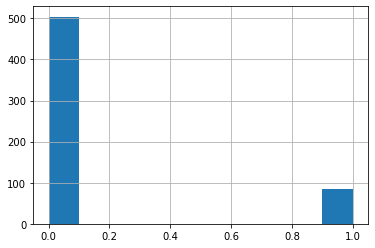

In [283]:
df['Relegated'].astype(int).hist();

Дисбаланс заметный. Нам нужно будет сравнивать долю верных ответов нашей модели с константным прогнозом о том, что команда не вылетит.

Выходит, доля правильных ответов у адекватного алгоритма должна быть 0.86 и больше...

In [284]:
df.head(3)

,Unnamed: 0,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,...,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game),League,Relegated
0,0,1,Manchester City,38,0.74,0.13,0.13,0.87,1.61,2.34,...,1,49.11,11.53,54.6,5.87,18.26,10.58,0.21,Premier League,0
1,1,2,Arsenal,38,0.68,0.16,0.16,1.13,1.18,2.21,...,1,52.21,12.79,46.5,6.24,21.18,15.76,0.58,Premier League,0
2,2,3,Manchester Utd,38,0.61,0.16,0.24,1.13,0.39,1.97,...,1,57.63,12.24,51.7,9.26,26.58,20.29,0.26,Premier League,0


In [285]:
df.drop(['Rk', 'Squad', 'League', 'Season', 'Unnamed: 0', 'MP'], axis=1, inplace=True) 
# первые два признака - откровенный спойлер, а лигу и год использовать бессмыленно

In [286]:
# дальше удалим очевидные признаки по типу забитых и пропущенных голов...
df.drop(['W (per game)', 'D (per game)', 'L (per game)', 'GA (per game)', 'GD (per game)',
         'Pts/MP', 'xGA (per game)', 'xGD/90', 'Top Team Scorer (per game)', 'Per 90 Minutes: Gls',
         'Per 90 Minutes: Ast', 'Per 90 Minutes: G+A', 'Per 90 Minutes: xG', 'Per 90 Minutes: xAG',
         'Per 90 Minutes: xG+xAG', 'Per 90 Minutes: npxG', 'Per 90 Minutes: npxG+xAG', 'Performance: CS%'],
        axis=1, inplace=True) 

In [287]:
# опция stratify делает разбиение на тест и трэйн сбалансированным по нашему таргету (Relegated)
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['Relegated'], random_state=1)

y_train = df_train['Relegated']
y_test = df_test['Relegated'] 
X_train = df_train.drop('Relegated', axis=1)
X_test = df_test.drop('Relegated', axis=1)

# смотрим метрику константного прогноза
y_pred = np.zeros_like(y_test)
accuracy_score(y_test, y_pred)

0.8587570621468926

Выходит, доля правильных ответов у адекватного алгоритма должна быть 0.86 и больше...

Стандартизируем признаки...

In [288]:
scaler = preprocessing.StandardScaler()
feature_names = X_train.columns
X_train[feature_names] = scaler.fit_transform(X_train)
X_test[feature_names] = scaler.transform(X_test)
X_train.head(3)

,Attendance,Pl,Age,Poss,Performance: PKatt,Performance: CrdY (per game),Performance: CrdR,Progression: PrgC (per game),Progression: PrgP,Per 90 Minutes: G-PK,...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
268,-0.255161,-0.704065,-0.452683,-0.986457,-0.388724,0.110192,0.128505,-0.490546,-0.423638,0.088074,...,-1.061155,0.329084,-0.456904,0.221608,-0.036653,0.431281,0.213560,0.698601,-0.495628,-0.762869
225,1.228565,0.126664,0.386526,1.046263,-1.087917,0.698194,-0.306009,0.327499,0.126818,0.458863,...,-1.467617,-0.794907,1.910165,-0.457583,-1.156717,-0.095807,0.410762,0.357281,0.703929,0.808568
363,-0.196961,-0.150245,1.057893,-1.002094,0.310469,-0.342116,-0.740522,-1.679116,-1.046616,0.296642,...,-0.248229,0.329084,-1.245927,0.167075,1.882651,0.121229,-1.764620,-1.591654,0.183639,-1.211850


Начнем с логистической регрессии.

In [289]:
model_lr = LogisticRegression() # объявляем модель

alphas = np.logspace(-100, 100, 200) # параметры регуляризации, которые будем подбирать по сетке

searcher_lr = GridSearchCV(model_lr, [{"C": alphas}],
                        scoring="roc_auc", cv=5, n_jobs=-1) # оценивать будем с помощью roc-auc
searcher_lr.fit(X_train, y_train)

best_alpha = searcher_lr.best_params_["C"] # смотрим на лучший параметр
best_alpha

0.31440354715914615

In [290]:
best_lr = LogisticRegression(C=0.314)
best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)
accuracy_score(y_test, y_pred) 

0.8926553672316384

Доля верных ответов заметно выше, чем у константного прогноза. Значит, алгоритм адекватный.

Теперь поглядим на KNN.

In [291]:
model_knn = KNeighborsClassifier()

k = np.linspace(5, 205, 21, dtype=int)

searcher_knn = GridSearchCV(model_knn, [{"n_neighbors": k}],
                        scoring="roc_auc", cv=5, n_jobs=-1)
searcher_knn.fit(X_train, y_train)

best_k = searcher_knn.best_params_["n_neighbors"]

In [292]:
y_pred = searcher_knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.8587570621468926

KNN по доле верных ответов даже не превзошел константный прогноз. Очевидно, стоит использовать логистическую регрессию.

In [293]:
p_pred = searcher_lr.predict_proba(X_test)[:, -1]

Теперь как-нибудь оценим наш классификатор, сделанный с помощью логистической регрессии. При этом не хочется заморачиваться с шевелением порога... <br> <br>
Для этого воспользуемся PR-кривой и ROC-кривой.

In [294]:
# стырили код из 10го семинара
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_test, p_pred):
    plt.figure(figsize=(7, 7))
    f_scores = np.linspace(0.4, 0.9, num=6)
    lines = []
    labels = []
    
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    
    pr_test = average_precision_score(y_test, p_pred)
    precision, recall, _ =  precision_recall_curve(y_test, p_pred)
    
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b', label='Test PR-AUC {0}'.format(pr_test))
    plt.xlabel('Recall', size=15)
    plt.ylabel('Precision', size=15)
    plt.title('Precision-Recall curve', size=18)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower right');

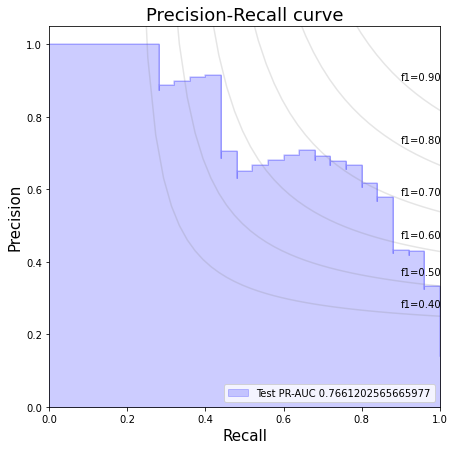

In [295]:
plot_precision_recall_curve(y_test, p_pred)

Мы довольно близки к точке (1, 1). Значит, модель хорошая.

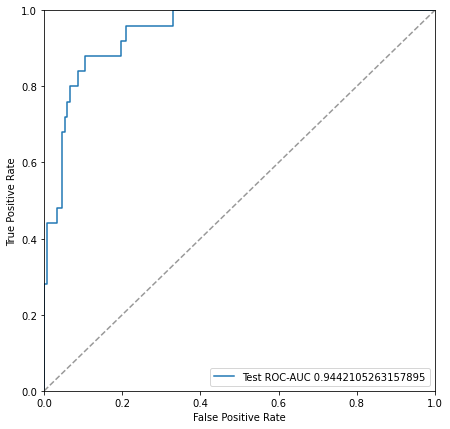

In [296]:
# опять стырили код из 10го семинара

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def roc_auc_pic(y_test, p_pred):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, p_pred)
    roc_auc_test = roc_auc_score(y_test, p_pred)

    plt.figure(figsize=(7, 7))
    plt.plot(fpr_test, tpr_test, label='Test ROC-AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right');
    
roc_auc_pic(y_test, p_pred)

__Очень хорошая модель!__

Теперь хотим глянуть на коэффициенты и посмотреть, что больше всего способствует вылету.

In [297]:
print('Что помогает команде не вылететь:')
for name, coef in sorted(list(zip(X_train.columns, best_lr.coef_[0])), key = lambda x: x[-1])[:10]:
    print(name, coef)
    
print('\nЭти показатели, наоборот, способствуют вылету:')
for name, coef in sorted(list(zip(X_train.columns, best_lr.coef_[0])), key = lambda x: x[-1])[-10:]:
    print(name, coef)

Что помогает команде не вылететь:
Performance: Save% -1.6575095241822164
Standard: SoT% -0.5085508616527495
Tackles: TklW (per game) -0.46385004942581554
Aerial Duels: Won% -0.41529070590378747
Expected: G-xG -0.37567849258655256
Attendance -0.3685408446439635
Expected: np:G-xG -0.3569372883283657
Standard: G/SoT -0.3426093171256988
Pass Types: CK (per game) -0.3411196056229176
GCA Types: Fld (per game) -0.339466295068406

Эти показатели, наоборот, способствуют вылету:
GCA Types: PassLive (per game) 0.2101165708645297
Performance: CrdR 0.21340558926275166
Pass Types: Sw (per game) 0.21416795168869185
SCA Types: TO (per game) 0.22668025921639964
Pl 0.22856856673996379
Int (per game) 0.258203438527192
Take-Ons: Tkld (per game) 0.306443286741419
Take-Ons: Att (per game) 0.34033432846676254
Pass Types: FK (per game) 0.3501999929964797
Performance: Saves (per game) 1.362399178457044


Итак, какие __выводы__ можно сделать?
- Самый важный показатель, спасающий от вылета - процент отраженных ударов вратарем. Вывод: не хотите вылететь - в первую очередь инвестируйте в классного вратаря, а потом уже думайте об остальном.
- Привлекайте фанатов на стадионы! Как мы видим, большая посещаемость тоже помогает команде остаться в лиге - видимо, поддержка болельщиков очень важна.
- Тренируйте игру в воздухе! Процент выигранных верховых дуэлей отрицательно связан с вероятностью вылета.
- Нужно реже давать бить по воротам своей команды. Наибольшим положительным коэффициентов является количество сейвов, а этот показатель в 99% случаев говорит о том, что по воротам просто очень часто бьют. Можно предложить командам не прижиматься к воротам и обороняться более высоко.
- Также стоит поменьше грубить. Количество красных карточек - 9-й признак по величине коэффициента перед ним. Обычно большое их количество свойственно вылетающим командам, однако трудно поверить в то, что их полное отсутствие поможет команде сохранить прописку. Скорее, это просто специфика команд, которые много обороняются. И пропускают - быть может, их игроки просто сильнее злятся из-за этого.